# ReTrain Step

In the attacks folder we have 25 fake images of 30km/h.

1. We will retrain network 1 with 20 images of fake 30km/h to make it learn they still are 30km/h.
2. We'll see if the other 5 fake images are still confusing the network or they don't work anymore.

In [2]:
import numpy as np 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Prepare training images
train_images = [1,2,3,4,5,12,13,14,15,16,17,19,24,25,27,28,30,31,33,34]

data = []
labels = []

for i in train_images:
  # Load image
  im = Image.open(os.path.join('drive','My Drive','TFG','attacks',str(i)+'_att.png'))
  im = im.resize((250,250))
  im = np.array(im)

  data.append(im)
  labels.append(1)

data = np.array(data)
labels = np.array(labels)

labels = to_categorical(labels, 43)

Epoch 1/5
2/2 [==============================] - 29s 16s/step - loss: 6.2392 - accuracy: 0.4500 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 2/5
2/2 [==============================] - 27s 16s/step - loss: 0.2452 - accuracy: 0.9000 - val_loss: 3.9159e-06 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 27s 16s/step - loss: 1.0544e-04 - accuracy: 1.0000 - val_loss: 1.0466e-05 - val_accuracy: 1.0000
Epoch 4/5
2/2 [==============================] - 27s 16s/step - loss: 2.5070e-05 - accuracy: 1.0000 - val_loss: 1.1646e-04 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 27s 16s/step - loss: 8.2190e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000


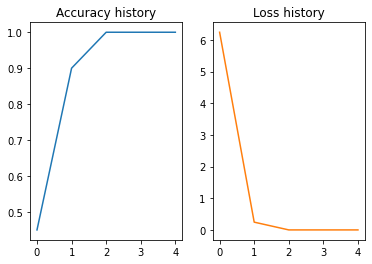

In [7]:
# ReTrain

network = os.path.join('drive','My Drive','TFG','models','1_v2','model.h5')
model = load_model(network)

epochs = 5

history_callback = model.fit(data,
                      labels,
                      batch_size=10,
                      epochs=epochs,
                      validation_data=(data, labels))

model.save(network)

# Save metrics
loss_history = history_callback.history["loss"]
acc_history = history_callback.history["accuracy"]

fig, (axs1, axs2) = plt.subplots(1, 2)
axs1.set_title('Accuracy history')
axs2.set_title('Loss history')
axs1.plot(acc_history)
axs2.plot(loss_history, 'tab:orange')

np.savetxt(os.path.join('drive','My Drive','TFG','models','1_v2', "loss_history.txt"), np.array(loss_history), delimiter=",")
np.savetxt(os.path.join('drive','My Drive','TFG','models','1_v2', "acc_history.txt"), np.array(acc_history), delimiter=",") 

# Sturdiness validation

Now that we have trained our model with the fake inputs, let's see if the other 5 still confuses the network or not. We have 3 possible scenarios:

1. The attack worked, the prediction is the same as the generated attack.
2. The attack didn't work but the network is confused, the prediction is random.
3. The attack didn't work, the prediction is what we would expect in the real world.

In [8]:
# Function to decode the predictions of a model
def decode_predictions(predictions):
  max_elem = np.max(predictions)
  result = np.where(predictions == max_elem)

  df = pd.read_csv(os.path.join('drive','My Drive','TFG','dataset','signnames.csv'))

  index = 4*result[0][0] + result[1][0]

  return df["SignName"][index]

In [11]:
network = os.path.join('drive','My Drive','TFG','models','1_v2','model.h5')
model = load_model(network)

test_images = [18,23,26,29,32]
results = []

for i in test_images:
  # Load image
  im = Image.open(os.path.join('drive','My Drive','TFG','attacks',str(i)+'_att.png'))
  im = im.resize((250,250))
  im = np.array(im)
  im = im.reshape([1, im.shape[0], im.shape[1], im.shape[2]])

  # Load metadata
  details = pd.read_csv(os.path.join('drive','My Drive','TFG','attacks','meta',str(i)+'_details.csv'))
  source_class = details["Original class"][0]
  target_class = details["Target class"][0]

  pred = decode_predictions(model.predict(im))

  print("Test {}:".format(i))
  print("    - I: '{}'".format(source_class))
  print("    - T: '{}'".format(target_class))
  print("    - O: '{}'".format(pred))

  if target_class == pred:
    results.append(1)
  elif pred == source_class:
    results.append(3)
  elif target_class!=pred and target_class!=source_class:
    results.append(2)
  else:
    results.append(4)

np.savetxt(os.path.join('drive','My Drive','TFG','attacks','test','retrain_results.csv'), np.array(results), delimiter=",")

Test 18:
    - I: 'Speed limit (30km/h)'
    - T: 'Speed limit (120km/h)'
    - O: 'Speed limit (30km/h)'
Test 23:
    - I: 'Speed limit (30km/h)'
    - T: 'End of speed limit (80km/h)'
    - O: 'Speed limit (30km/h)'
Test 26:
    - I: 'Speed limit (30km/h)'
    - T: 'Speed limit (120km/h)'
    - O: 'Speed limit (30km/h)'
Test 29:
    - I: 'Speed limit (30km/h)'
    - T: 'End of speed limit (80km/h)'
    - O: 'Speed limit (30km/h)'
Test 32:
    - I: 'Speed limit (30km/h)'
    - T: 'Speed limit (120km/h)'
    - O: 'Speed limit (30km/h)'


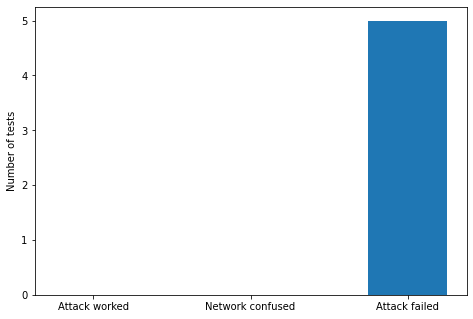

[0, 0, 5]


<Figure size 432x288 with 0 Axes>

In [15]:
data = np.genfromtxt(os.path.join('drive','My Drive','TFG','attacks','test','retrain_results.csv'),delimiter=',')

# draw histogram
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
axis = ['Attack worked', 'Network confused', 'Attack failed']
data = [len(data[data==1]),len(data[data==2]),len(data[data==3])]
ax.bar(axis,data, 0.5)

plt.ylabel('Number of tests')
plt.show()
plt.savefig(os.path.join('drive','My Drive','TFG','attacks','test','retrain_histogram.svg'))

print(data)